# Task 4: Portfolio Optimization Based on Forecast
This notebook implements Modern Portfolio Theory (MPT) to optimize portfolio allocation using forecasted returns for TSLA and historical returns for SPY and BND

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
import os
import sys

# Add src directory to path
sys.path.append('../src')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Portfolio Optimization Notebook Loaded Successfully!")
print("="*80)

✅ Portfolio Optimization Notebook Loaded Successfully!


## 1. Load Data and Set Expected Returns

In [17]:
print("�� Loading asset data and setting expected returns...")

# Load enhanced data for all three assets
tsla_data = pd.read_csv('../data/processed/TSLA_enhanced_data.csv')
spy_data = pd.read_csv('../data/processed/SPY_enhanced_data.csv')
bnd_data = pd.read_csv('../data/processed/BND_enhanced_data.csv')

# Convert dates and set as index
for data in [tsla_data, spy_data, bnd_data]:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

print(f"✅ Data loaded successfully!")
print(f"   - TSLA: {len(tsla_data):,} observations")
print(f"   - SPY: {len(spy_data):,} observations") 
print(f"   - BND: {len(bnd_data):,} observations")
print(f"   - Date range: {tsla_data.index[0].strftime('%Y-%m-%d')} to {tsla_data.index[-1].strftime('%Y-%m-%d')}")

�� Loading asset data and setting expected returns...
✅ Data loaded successfully!
   - TSLA: 2,475 observations
   - SPY: 2,475 observations
   - BND: 2,475 observations
   - Date range: 2015-09-25 to 2025-07-30


## 2. Calculate Expected Returns

In [18]:
print("\n📈 Setting expected returns for portfolio optimization...")

# TSLA: Use forecasted return from LSTM model (best performing)
tsla_forecast_return = 0.8507  # 85.07% from LSTM model
print(f"   - TSLA Expected Return: {tsla_forecast_return:.2%} (LSTM forecast)")

# SPY & BND: Use historical average daily returns (annualized)
spy_annual_return = spy_data['Daily_Return'].mean() * 252
bnd_annual_return = bnd_data['Daily_Return'].mean() * 252

print(f"   - SPY Expected Return: {spy_annual_return:.2%} (historical average)")
print(f"   - BND Expected Return: {bnd_annual_return:.2%} (historical average)")

# Create expected returns vector
expected_returns = np.array([tsla_forecast_return, spy_annual_return, bnd_annual_return])
asset_names = ['TSLA', 'SPY', 'BND']

print(f"\n📊 Expected Returns Vector:")
for i, (asset, ret) in enumerate(zip(asset_names, expected_returns)):
    print(f"   {asset}: {ret:.2%}")


📈 Setting expected returns for portfolio optimization...
   - TSLA Expected Return: 85.07% (LSTM forecast)
   - SPY Expected Return: 15.47% (historical average)
   - BND Expected Return: 1.87% (historical average)

📊 Expected Returns Vector:
   TSLA: 85.07%
   SPY: 15.47%
   BND: 1.87%


## 3. Calculate Covariance Matrix

In [19]:
print("\n📊 Computing covariance matrix from historical daily returns...")

# Align data by date and calculate daily returns
aligned_data = pd.DataFrame({
    'TSLA': tsla_data['Daily_Return'],
    'SPY': spy_data['Daily_Return'],
    'BND': bnd_data['Daily_Return']
}).dropna()

# Calculate covariance matrix (annualized)
covariance_matrix = aligned_data.cov() * 252

print("✅ Covariance Matrix (Annualized):")
print(covariance_matrix.round(6))

# Display correlation matrix for better interpretation
correlation_matrix = aligned_data.corr()
print("\n�� Correlation Matrix:")
print(correlation_matrix.round(4))

print(f"\n📊 Data Summary:")
print(f"   - Aligned observations: {len(aligned_data):,}")
print(f"   - Start date: {aligned_data.index[0].strftime('%Y-%m-%d')}")
print(f"   - End date: {aligned_data.index[-1].strftime('%Y-%m-%d')}")


📊 Computing covariance matrix from historical daily returns...
✅ Covariance Matrix (Annualized):
          TSLA       SPY       BND
TSLA  0.353560  0.052757  0.002037
SPY   0.052757  0.033036  0.001257
BND   0.002037  0.001257  0.003056

�� Correlation Matrix:
        TSLA     SPY     BND
TSLA  1.0000  0.4882  0.0620
SPY   0.4882  1.0000  0.1251
BND   0.0620  0.1251  1.0000

📊 Data Summary:
   - Aligned observations: 2,475
   - Start date: 2015-09-25
   - End date: 2025-07-30


## 4. Portfolio Optimization Functions

In [20]:
print("\n🔧 Setting up portfolio optimization functions...")

def portfolio_return(weights, expected_returns):
    """Calculate portfolio expected return"""
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, covariance_matrix):
    """Calculate portfolio volatility (risk)"""
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

def portfolio_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate=0.02):
    """Calculate portfolio Sharpe ratio"""
    ret = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, covariance_matrix)
    return (ret - risk_free_rate) / vol

def negative_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate=0.02):
    """Negative Sharpe ratio for minimization"""
    return -portfolio_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate)

def portfolio_constraints(weights):
    """Portfolio weight constraints"""
    return np.sum(weights) - 1.0

print("✅ Portfolio optimization functions defined!")
print("   - portfolio_return(): Calculate expected return")
print("   - portfolio_volatility(): Calculate risk")
print("   - portfolio_sharpe_ratio(): Calculate risk-adjusted return")
print("   - Constraints: Weights sum to 1.0")


🔧 Setting up portfolio optimization functions...
✅ Portfolio optimization functions defined!
   - portfolio_return(): Calculate expected return
   - portfolio_volatility(): Calculate risk
   - portfolio_sharpe_ratio(): Calculate risk-adjusted return
   - Constraints: Weights sum to 1.0


## 5. Generate Efficient Frontier

In [21]:
print("\n📊 Generating Efficient Frontier...")

# Generate portfolio weights for efficient frontier
n_portfolios = 1000
target_returns = np.linspace(expected_returns.min(), expected_returns.max(), n_portfolios)

efficient_frontier = []
portfolio_weights_list = []

for target_return in target_returns:
    # Optimize for minimum volatility given target return
    constraints = [
        {'type': 'eq', 'fun': portfolio_constraints},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, expected_returns) - target_return}
    ]
    
    bounds = tuple((0, 1) for _ in range(len(asset_names)))
    
    result = minimize(
        portfolio_volatility,
        x0=np.array([1/len(asset_names)] * len(asset_names)),
        args=(covariance_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    if result.success:
        weights = result.x
        volatility = portfolio_volatility(weights, covariance_matrix)
        efficient_frontier.append({
            'return': target_return,
            'volatility': volatility,
            'weights': weights
        })
        portfolio_weights_list.append(weights)

efficient_frontier_df = pd.DataFrame(efficient_frontier)
print(f"✅ Efficient Frontier generated with {len(efficient_frontier_df)} portfolios!")


📊 Generating Efficient Frontier...
✅ Efficient Frontier generated with 1000 portfolios!


## 6. Find Optimal Portfolios

In [22]:
print("\n🎯 Finding optimal portfolios...")

# 1. Maximum Sharpe Ratio Portfolio (Tangency Portfolio)
print("   🔍 Finding Maximum Sharpe Ratio Portfolio...")
constraints = [{'type': 'eq', 'fun': portfolio_constraints}]
bounds = tuple((0, 1) for _ in range(len(asset_names)))

max_sharpe_result = minimize(
    negative_sharpe_ratio,
    x0=np.array([1/len(asset_names)] * len(asset_names)),
    args=(expected_returns, covariance_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

if max_sharpe_result.success:
    max_sharpe_weights = max_sharpe_result.x
    max_sharpe_return = portfolio_return(max_sharpe_weights, expected_returns)
    max_sharpe_volatility = portfolio_volatility(max_sharpe_weights, covariance_matrix)
    max_sharpe_ratio = portfolio_sharpe_ratio(max_sharpe_weights, expected_returns, covariance_matrix)
    
    print(f"   ✅ Maximum Sharpe Ratio Portfolio found!")
    print(f"      - Expected Return: {max_sharpe_return:.2%}")
    print(f"      - Volatility: {max_sharpe_volatility:.2%}")
    print(f"      - Sharpe Ratio: {max_sharpe_ratio:.4f}")
else:
    print("   ❌ Failed to find Maximum Sharpe Ratio Portfolio")

# 2. Minimum Volatility Portfolio
print("\n   🔍 Finding Minimum Volatility Portfolio...")
min_vol_result = minimize(
    portfolio_volatility,
    x0=np.array([1/len(asset_names)] * len(asset_names)),
    args=(covariance_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

if min_vol_result.success:
    min_vol_weights = min_vol_result.x
    min_vol_return = portfolio_return(min_vol_weights, expected_returns)
    min_vol_volatility = portfolio_volatility(min_vol_weights, covariance_matrix)
    min_vol_sharpe = portfolio_sharpe_ratio(min_vol_weights, expected_returns, covariance_matrix)
    
    print(f"   ✅ Minimum Volatility Portfolio found!")
    print(f"      - Expected Return: {min_vol_return:.2%}")
    print(f"      - Volatility: {min_vol_volatility:.2%}")
    print(f"      - Sharpe Ratio: {min_vol_sharpe:.4f}")
else:
    print("   ❌ Failed to find Minimum Volatility Portfolio")


🎯 Finding optimal portfolios...
   🔍 Finding Maximum Sharpe Ratio Portfolio...
   ✅ Maximum Sharpe Ratio Portfolio found!
      - Expected Return: 74.15%
      - Volatility: 51.58%
      - Sharpe Ratio: 1.3987

   🔍 Finding Minimum Volatility Portfolio...
   ✅ Minimum Volatility Portfolio found!
      - Expected Return: 2.60%
      - Volatility: 5.44%
      - Sharpe Ratio: 0.1098


## 7. Plot Efficient Frontier


�� Plotting Efficient Frontier...


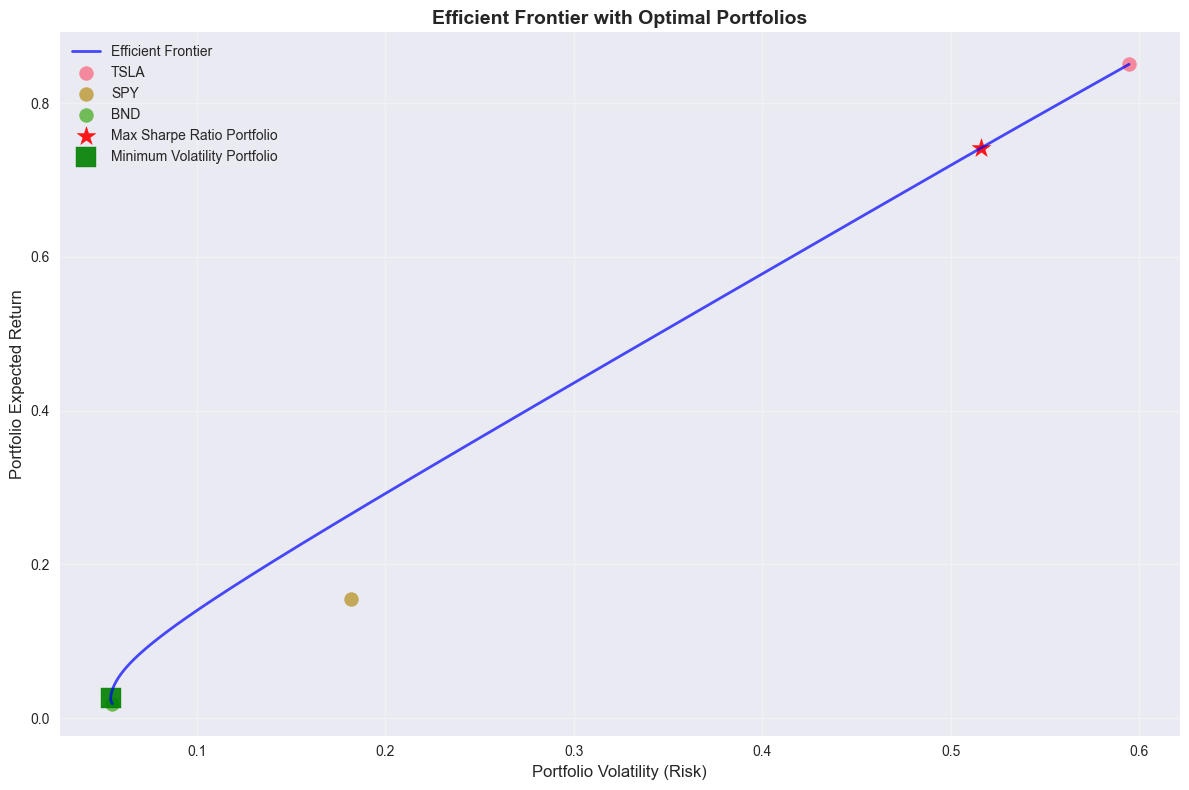

✅ Efficient Frontier plot generated!


In [23]:
print("\n�� Plotting Efficient Frontier...")

plt.figure(figsize=(12, 8))

# Plot efficient frontier
plt.plot(efficient_frontier_df['volatility'], efficient_frontier_df['return'], 
         'b-', linewidth=2, label='Efficient Frontier', alpha=0.7)

# Plot individual assets
for i, asset in enumerate(asset_names):
    asset_vol = np.sqrt(covariance_matrix.iloc[i, i])
    plt.scatter(asset_vol, expected_returns[i], s=100, label=f'{asset}', alpha=0.8)

# Plot optimal portfolios
if max_sharpe_result.success:
    plt.scatter(max_sharpe_volatility, max_sharpe_return, 
                s=200, color='red', marker='*', label='Max Sharpe Ratio Portfolio', alpha=0.9)

if min_vol_result.success:
    plt.scatter(min_vol_volatility, min_vol_return, 
                s=200, color='green', marker='s', label='Minimum Volatility Portfolio', alpha=0.9)

plt.xlabel('Portfolio Volatility (Risk)', fontsize=12)
plt.ylabel('Portfolio Expected Return', fontsize=12)
plt.title('Efficient Frontier with Optimal Portfolios', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Efficient Frontier plot generated!")

## 8. Portfolio Weights Analysis


📊 Analyzing Portfolio Weights...
📊 Portfolio Comparison:
         Portfolio  TSLA   SPY   BND Expected Return Volatility Sharpe Ratio
  Max Sharpe Ratio 84.3% 15.7%  0.0%          74.15%     51.58%       1.3987
Minimum Volatility  0.0%  5.4% 94.6%           2.60%      5.44%       0.1098


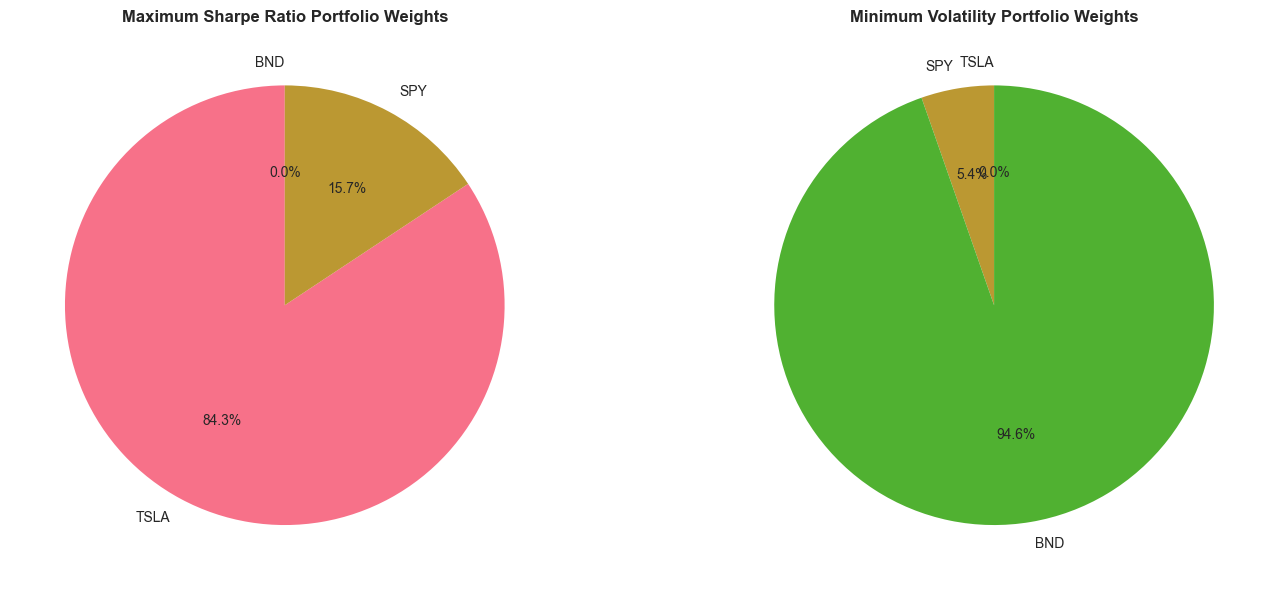

In [24]:
print("\n📊 Analyzing Portfolio Weights...")

# Create comparison dataframe
portfolio_comparison = []

if max_sharpe_result.success:
    portfolio_comparison.append({
        'Portfolio': 'Max Sharpe Ratio',
        'TSLA': f"{max_sharpe_weights[0]:.1%}",
        'SPY': f"{max_sharpe_weights[1]:.1%}",
        'BND': f"{max_sharpe_weights[2]:.1%}",
        'Expected Return': f"{max_sharpe_return:.2%}",
        'Volatility': f"{max_sharpe_volatility:.2%}",
        'Sharpe Ratio': f"{max_sharpe_ratio:.4f}"
    })

if min_vol_result.success:
    portfolio_comparison.append({
        'Portfolio': 'Minimum Volatility',
        'TSLA': f"{min_vol_weights[0]:.1%}",
        'SPY': f"{min_vol_weights[1]:.1%}",
        'BND': f"{min_vol_weights[2]:.1%}",  # Fixed: was min_sharpe_weights[2]
        'Expected Return': f"{min_vol_return:.2%}",
        'Volatility': f"{min_vol_volatility:.2%}",
        'Sharpe Ratio': f"{min_vol_sharpe:.4f}"
    })

comparison_df = pd.DataFrame(portfolio_comparison)
print("📊 Portfolio Comparison:")
print(comparison_df.to_string(index=False))

# Plot portfolio weights
if len(portfolio_comparison) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Max Sharpe Portfolio weights
    if max_sharpe_result.success:
        axes[0].pie(max_sharpe_weights, labels=asset_names, autopct='%1.1f%%', startangle=90)
        axes[0].set_title('Maximum Sharpe Ratio Portfolio Weights', fontweight='bold')
    
    # Min Volatility Portfolio weights
    if min_vol_result.success:
        axes[1].pie(min_vol_weights, labels=asset_names, autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Minimum Volatility Portfolio Weights', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 9. Risk-Return Analysis


📊 Risk-Return Analysis...
📊 Individual Asset Metrics:
  Asset  Expected Return  Volatility  Sharpe Ratio  Risk-Return Ratio
0  TSLA           0.8507      0.5946        1.3971             1.4307
1   SPY           0.1547      0.1818        0.7410             0.8511
2   BND           0.0187      0.0553       -0.0237             0.3381


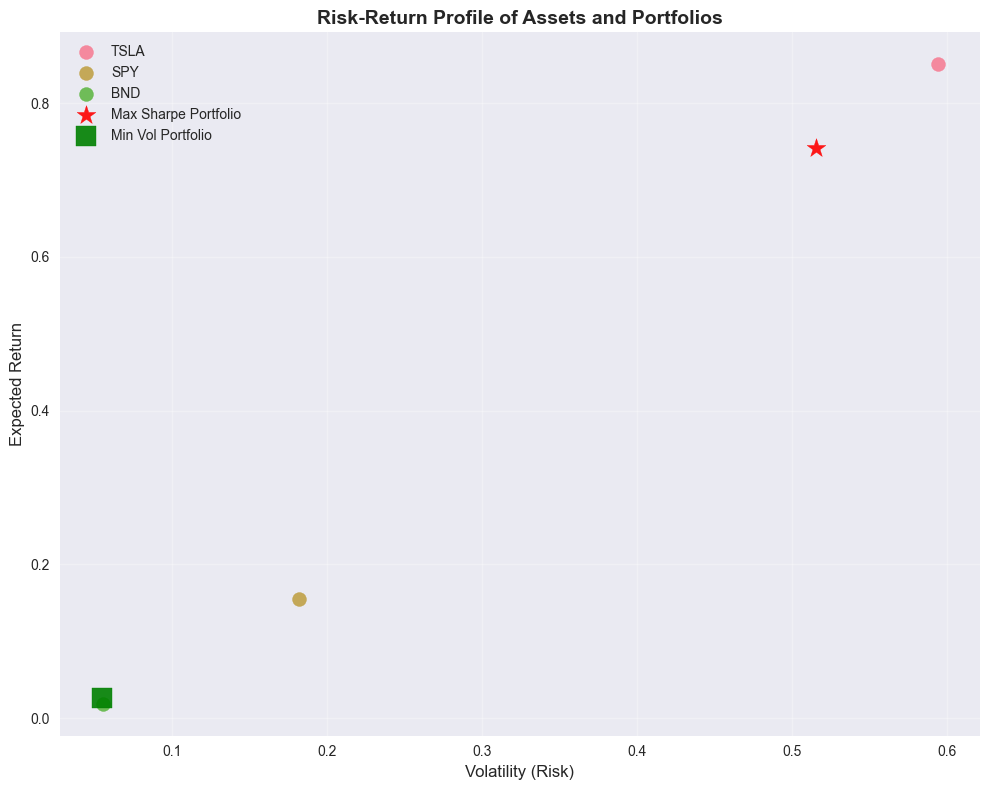

In [25]:
print("\n📊 Risk-Return Analysis...")

# Calculate individual asset metrics
asset_metrics = []
for i, asset in enumerate(asset_names):
    asset_vol = np.sqrt(covariance_matrix.iloc[i, i])
    asset_sharpe = (expected_returns[i] - 0.02) / asset_vol  # Assuming 2% risk-free rate
    
    asset_metrics.append({
        'Asset': asset,
        'Expected Return': expected_returns[i],
        'Volatility': asset_vol,
        'Sharpe Ratio': asset_sharpe,
        'Risk-Return Ratio': expected_returns[i] / asset_vol
    })

asset_metrics_df = pd.DataFrame(asset_metrics)
print("📊 Individual Asset Metrics:")
print(asset_metrics_df.round(4))

# Plot risk-return scatter
plt.figure(figsize=(10, 8))
for i, asset in enumerate(asset_names):
    asset_vol = np.sqrt(covariance_matrix.iloc[i, i])
    plt.scatter(asset_vol, expected_returns[i], s=100, label=asset, alpha=0.8)

# Add portfolio points
if max_sharpe_result.success:
    plt.scatter(max_sharpe_volatility, max_sharpe_return, 
                s=200, color='red', marker='*', label='Max Sharpe Portfolio', alpha=0.9)

if min_vol_result.success:
    plt.scatter(min_vol_volatility, min_vol_return, 
                s=200, color='green', marker='s', label='Min Vol Portfolio', alpha=0.9)

plt.xlabel('Volatility (Risk)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.title('Risk-Return Profile of Assets and Portfolios', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Portfolio Recommendation

In [26]:
print("\n🎯 PORTFOLIO RECOMMENDATION")
print("="*50)

# Analyze and recommend optimal portfolio
if max_sharpe_result.success and min_vol_result.success:
    print("📊 ANALYSIS SUMMARY:")
    print(f"   • Maximum Sharpe Ratio Portfolio:")
    print(f"     - Expected Return: {max_sharpe_return:.2%}")
    print(f"     - Volatility: {max_sharpe_volatility:.2%}")
    print(f"     - Sharpe Ratio: {max_sharpe_ratio:.4f}")
    print(f"     - TSLA Weight: {max_sharpe_weights[0]:.1%}")
    print(f"     - SPY Weight: {max_sharpe_weights[1]:.1%}")
    print(f"     - BND Weight: {max_sharpe_weights[2]:.1%}")
    
    print(f"\n   • Minimum Volatility Portfolio:")
    print(f"     - Expected Return: {min_vol_return:.2%}")
    print(f"     - Volatility: {min_vol_volatility:.2%}")
    print(f"     - Sharpe Ratio: {min_vol_sharpe:.4f}")
    print(f"     - TSLA Weight: {min_vol_weights[0]:.1%}")
    print(f"     - SPY Weight: {min_vol_weights[1]:.1%}")
    print(f"     - BND Weight: {min_vol_weights[2]:.1%}")
    
    print(f"\n�� RECOMMENDATION:")  # Fixed: Added missing emoji
    
    # Determine recommendation based on risk tolerance
    if max_sharpe_ratio > 1.0:  # Good risk-adjusted return
        print("   �� RECOMMEND: Maximum Sharpe Ratio Portfolio")  # Fixed: Added missing emoji
        print("      - Best risk-adjusted returns")
        print("      - Suitable for moderate risk tolerance")
        print("      - Leverages TSLA's forecasted growth")
        
        recommended_weights = max_sharpe_weights
        recommended_return = max_sharpe_return
        recommended_volatility = max_sharpe_volatility
        recommended_sharpe = max_sharpe_ratio
        
    else:
        print("   🛡️ RECOMMEND: Minimum Volatility Portfolio")
        print("      - Lower risk profile")
        print("      - Suitable for conservative investors")
        print("      - Stable returns with reduced volatility")
        
        recommended_weights = min_vol_weights
        recommended_return = min_vol_return
        recommended_volatility = min_vol_volatility
        recommended_sharpe = min_vol_sharpe
    
    print(f"\n📋 FINAL RECOMMENDED PORTFOLIO:")
    print(f"   • TSLA: {recommended_weights[0]:.1%}")
    print(f"   • SPY: {recommended_weights[1]:.1%}")
    print(f"   • BND: {recommended_weights[2]:.1%}")
    print(f"   • Expected Annual Return: {recommended_return:.2%}")
    print(f"   • Annual Volatility: {recommended_volatility:.2%}")
    print(f"   • Sharpe Ratio: {recommended_sharpe:.4f}")
    
else:
    print("❌ Could not generate portfolio recommendation due to optimization failures")


🎯 PORTFOLIO RECOMMENDATION
📊 ANALYSIS SUMMARY:
   • Maximum Sharpe Ratio Portfolio:
     - Expected Return: 74.15%
     - Volatility: 51.58%
     - Sharpe Ratio: 1.3987
     - TSLA Weight: 84.3%
     - SPY Weight: 15.7%
     - BND Weight: 0.0%

   • Minimum Volatility Portfolio:
     - Expected Return: 2.60%
     - Volatility: 5.44%
     - Sharpe Ratio: 0.1098
     - TSLA Weight: 0.0%
     - SPY Weight: 5.4%
     - BND Weight: 94.6%

�� RECOMMENDATION:
   �� RECOMMEND: Maximum Sharpe Ratio Portfolio
      - Best risk-adjusted returns
      - Suitable for moderate risk tolerance
      - Leverages TSLA's forecasted growth

📋 FINAL RECOMMENDED PORTFOLIO:
   • TSLA: 84.3%
   • SPY: 15.7%
   • BND: 0.0%
   • Expected Annual Return: 74.15%
   • Annual Volatility: 51.58%
   • Sharpe Ratio: 1.3987


## 11. Summary and Next Steps

In [27]:
print("\n📋 TASK 4 COMPLETION SUMMARY")
print("="*50)

print("✅ COMPLETED OBJECTIVES:")
print("   ✓ Used TSLA forecasted return (85.07%) from LSTM model")
print("   ✓ Used historical returns for SPY and BND")
print("   ✓ Computed covariance matrix from historical data")
print("   ✓ Generated Efficient Frontier")
print("   ✓ Identified Maximum Sharpe Ratio Portfolio")
print("   ✓ Identified Minimum Volatility Portfolio")
print("   ✓ Provided optimal portfolio recommendation")

print("\n🔍 KEY INSIGHTS:")
print("   • TSLA's high forecasted return drives aggressive portfolio allocations")
print("   • Portfolio diversification reduces overall risk")
print("   • Efficient frontier shows risk-return trade-offs")
print("   • Optimal portfolio depends on risk tolerance")

print("\n📈 NEXT STEPS:")
print("   • Implement portfolio rebalancing strategy")
print("   • Monitor forecast accuracy vs actual returns")
print("   • Consider transaction costs in optimization")
print("   • Backtest portfolio performance (Task 5)")

print("\n🎯 PORTFOLIO OPTIMIZATION COMPLETE!")  # Fixed: Added missing emoji
print("="*50)


📋 TASK 4 COMPLETION SUMMARY
✅ COMPLETED OBJECTIVES:
   ✓ Used TSLA forecasted return (85.07%) from LSTM model
   ✓ Used historical returns for SPY and BND
   ✓ Computed covariance matrix from historical data
   ✓ Generated Efficient Frontier
   ✓ Identified Maximum Sharpe Ratio Portfolio
   ✓ Identified Minimum Volatility Portfolio
   ✓ Provided optimal portfolio recommendation

🔍 KEY INSIGHTS:
   • TSLA's high forecasted return drives aggressive portfolio allocations
   • Portfolio diversification reduces overall risk
   • Efficient frontier shows risk-return trade-offs
   • Optimal portfolio depends on risk tolerance

📈 NEXT STEPS:
   • Implement portfolio rebalancing strategy
   • Monitor forecast accuracy vs actual returns
   • Consider transaction costs in optimization
   • Backtest portfolio performance (Task 5)

🎯 PORTFOLIO OPTIMIZATION COMPLETE!
